# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)

Using PyTorch version: 0.4.0 CUDA: True


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [2]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

Processing...
Done!


The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

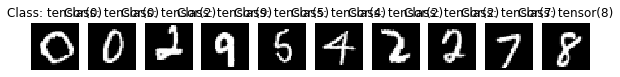

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x))

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `test()` the model. 

In [6]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [7]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `test()`. 

In [8]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

/home/junny/anaconda3/envs/code_session/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/junny/anaconda3/envs/code_session/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288293
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.135673
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.543976
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.030079
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.011133
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.748989
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.895010
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.710413
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.767389
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.810629
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.426286
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.554145
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.674163
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.324517
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.821185
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.298282
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.638260
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.773426
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.766047


/home/junny/anaconda3/envs/code_session/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/junny/anaconda3/envs/code_session/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':



Validation set: Average loss: 0.3101, Accuracy: 9094/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.637402
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.520893
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.481638
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.344016
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.511155
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.318445
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.149644
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.528509
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.512982
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.403993
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.306976
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.239222
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.408757
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.405315
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.218886
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.474091
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.267352
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.149619
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0

Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.043288
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.112717
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.093079
Train Epoch: 10 [16000/60000 (27%)]	Loss: 0.168060
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.206318
Train Epoch: 10 [22400/60000 (37%)]	Loss: 0.483260
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.075813
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.364034
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.180531
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.537869
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.180226
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.099035
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.190709
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.173728
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.206690
Train Epoch: 10 [54400/60000 (91%)]	Loss: 0.085271
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.137211

Validation set: Average loss: 0.1134, Accuracy: 9639/10000 (96%)

CPU times: user 35 s, sys: 4.39 s, total: 39.4 s
Wall time: 1min 11s

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

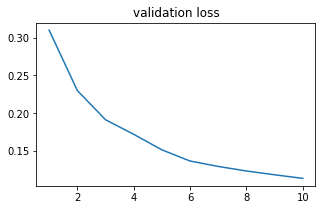

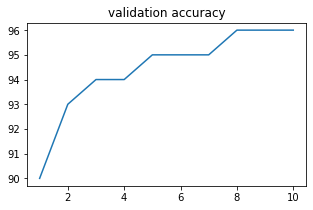

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');